In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy

# Set up matplotlib for better plots in Jupyter
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [ ]:
# Cell 2: Load and examine the data
def load_strata_results(csv_file="strata_verify_results.csv"):
    """Load StrataVerify benchmark results from CSV file."""
    
    if not os.path.exists(csv_file):
        print(f"Error: CSV file '{csv_file}' not found")
        return None
    
    try:
        df = pd.read_csv(csv_file)
        print(f"✅ Loaded {len(df)} results from {csv_file}")
        return df
    except Exception as e:
        print(f"❌ Error reading CSV file: {e}")
        return None

# Load the data
df = load_strata_results("strata_verify_results_typechecking_only.csv")

# Display basic info about the dataset
if df is not None:
    print(f"\nDataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    display(df.head())



✅ Loaded 7 results from strata_verify_results.csv

Dataset shape: (7, 3)
Columns: ['filename', 'line_count', 'execution_time_seconds']


,filename,line_count,execution_time_seconds
0,ContainerHeapAffine12.boogie.st,292,63.966613
1,ContainerHeapAffine4.boogie.st,248,39.945120
2,ContainerHeapAffine8.boogie.st,270,51.561076
3,ContainerHeapClassic12.boogie.st,283,228.590530
4,ContainerHeapClassic4.boogie.st,238,66.462185


In [17]:
if df is not None:
    print("📊 SUMMARY STATISTICS")
    print("=" * 50)
    print(f"Total files processed: {len(df)}")
    print(f"Average execution time: {df['execution_time_seconds'].mean():.2f}s")
    print(f"Median execution time: {df['execution_time_seconds'].median():.2f}s")
    print(f"Standard deviation: {df['execution_time_seconds'].std():.2f}s")
    print(f"Slowest file: {df.loc[df['execution_time_seconds'].idxmax(), 'filename']} ({df['execution_time_seconds'].max():.2f}s)")
    print(f"Fastest file: {df.loc[df['execution_time_seconds'].idxmin(), 'filename']} ({df['execution_time_seconds'].min():.2f}s)")
    print(f"Average file size: {df['line_count'].mean():.0f} lines")
    print(f"Largest file: {df.loc[df['line_count'].idxmax(), 'filename']} ({df['line_count'].max()} lines)")
    
    # Display descriptive statistics
    print("\n📈 Detailed Statistics:")
    display(df[['line_count', 'execution_time_seconds']].describe())

📊 SUMMARY STATISTICS
Total files processed: 7
Average execution time: 94.84s
Median execution time: 66.46s
Standard deviation: 64.41s
Slowest file: ContainerHeapClassic12.boogie.st (228.59s)
Fastest file: ContainerHeapAffine4.boogie.st (39.95s)
Average file size: 263 lines
Largest file: ContainerHeapAffine12.boogie.st (292 lines)

📈 Detailed Statistics:


,line_count,execution_time_seconds
count,7.000000,7.000000
mean,263.000000,94.836007
std,19.450793,64.414522
min,238.000000,39.945120
25%,251.000000,57.763845
50%,256.000000,66.462185
75%,276.500000,106.663262
max,292.000000,228.590530


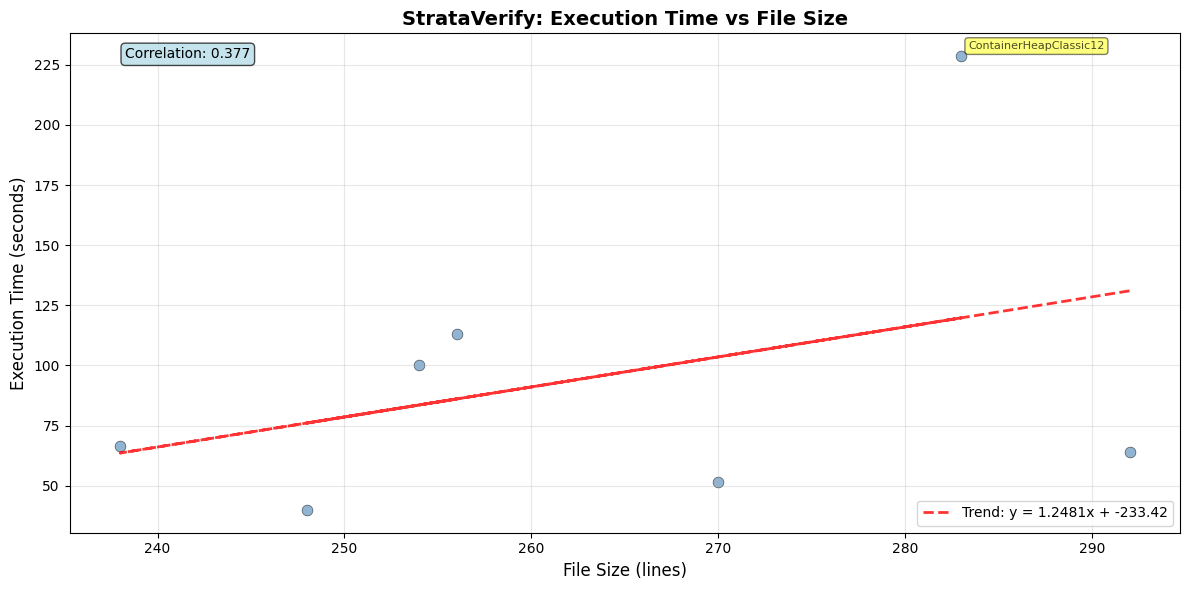

In [18]:
if df is not None:
    plt.figure(figsize=(12, 6))
    
    # Create scatter plot
    plt.scatter(df['line_count'], df['execution_time_seconds'], 
                alpha=0.6, s=60, c='steelblue', edgecolors='black', linewidth=0.5)
    
    # Add trend line
    z = np.polyfit(df['line_count'], df['execution_time_seconds'], 1)
    p = np.poly1d(z)
    plt.plot(df['line_count'], p(df['line_count']), "r--", alpha=0.8, linewidth=2,
             label=f'Trend: y = {z[0]:.4f}x + {z[1]:.2f}')
    
    # Annotate outliers (top 10% slowest)
    threshold = df['execution_time_seconds'].quantile(0.9)
    outliers = df[df['execution_time_seconds'] > threshold]
    
    for _, row in outliers.iterrows():
        plt.annotate(row['filename'].replace('.boogie.st', ''), 
                    (row['line_count'], row['execution_time_seconds']),
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=8, alpha=0.7,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))
    
    plt.xlabel('File Size (lines)', fontsize=12)
    plt.ylabel('Execution Time (seconds)', fontsize=12)
    plt.title('StrataVerify: Execution Time vs File Size', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Calculate correlation
    correlation = df['line_count'].corr(df['execution_time_seconds'])
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    
    plt.tight_layout()
    plt.show()

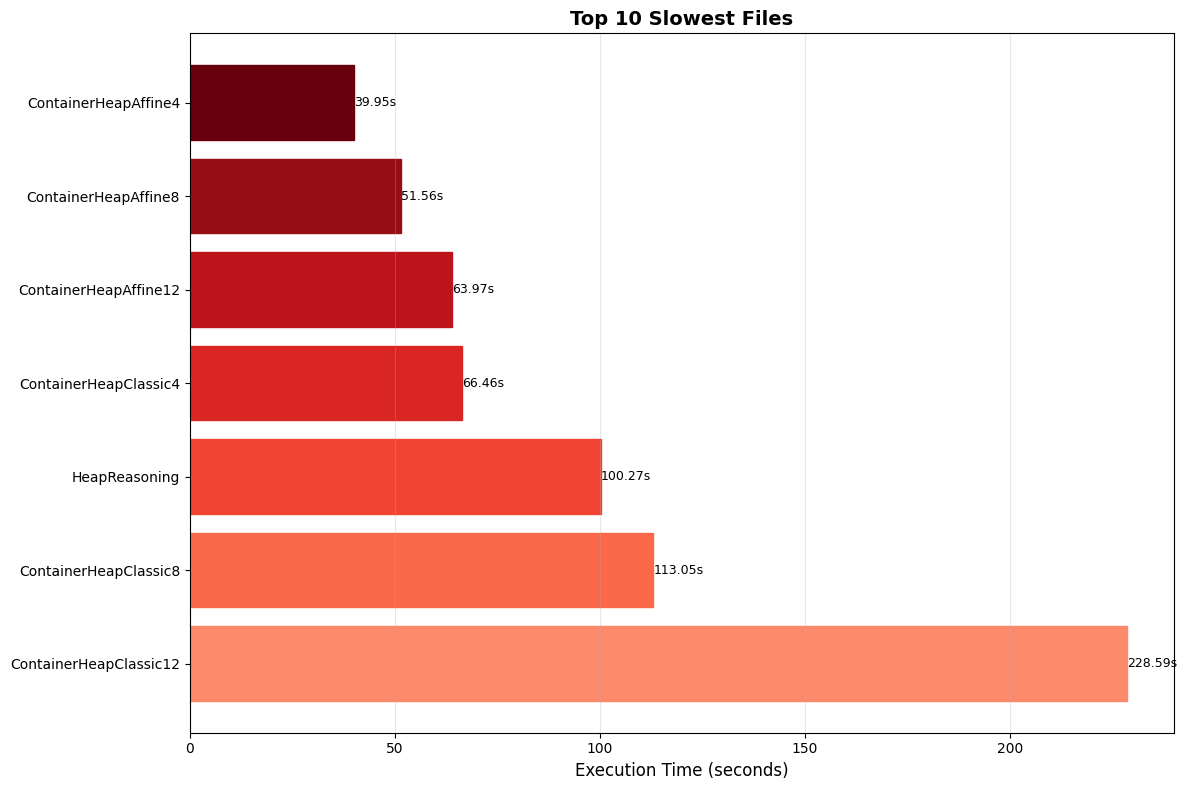

In [19]:
if df is not None:
    plt.figure(figsize=(12, 8))
    
    top_slow = df.nlargest(10, 'execution_time_seconds')
    
    # Create horizontal bar chart
    bars = plt.barh(range(len(top_slow)), top_slow['execution_time_seconds'])
    
    # Color bars by execution time (gradient)
    colors = plt.cm.Reds(np.linspace(0.4, 1, len(bars)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # Customize the plot
    plt.yticks(range(len(top_slow)), 
               [f.replace('.boogie.st', '') for f in top_slow['filename']])
    plt.xlabel('Execution Time (seconds)', fontsize=12)
    plt.title('Top 10 Slowest Files', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add value labels on bars
    for i, (bar, time) in enumerate(zip(bars, top_slow['execution_time_seconds'])):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{time:.2f}s', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

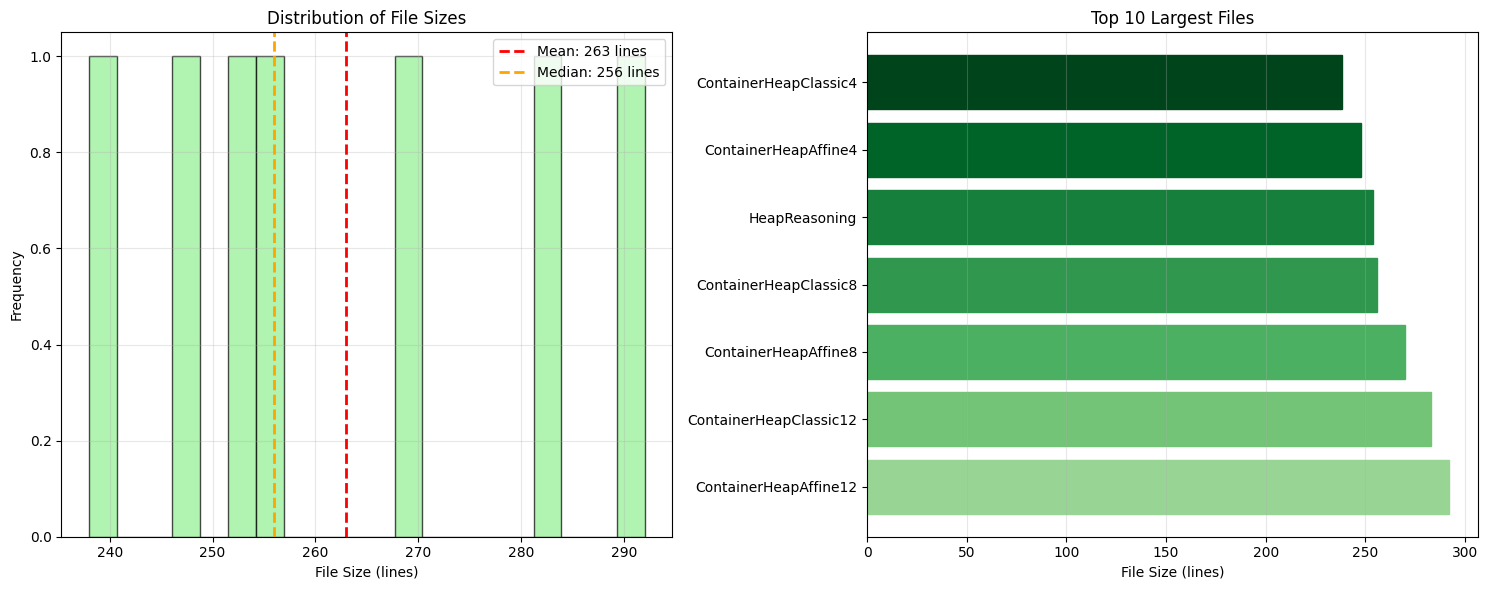

In [20]:
if df is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # File size histogram
    ax1.hist(df['line_count'], bins=20, alpha=0.7, 
             color='lightgreen', edgecolor='black')
    ax1.axvline(df['line_count'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {df["line_count"].mean():.0f} lines')
    ax1.axvline(df['line_count'].median(), color='orange', linestyle='--', linewidth=2,
                label=f'Median: {df["line_count"].median():.0f} lines')
    ax1.set_xlabel('File Size (lines)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of File Sizes')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Largest files
    top_large = df.nlargest(10, 'line_count')
    bars = ax2.barh(range(len(top_large)), top_large['line_count'])
    
    colors = plt.cm.Greens(np.linspace(0.4, 1, len(bars)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    ax2.set_yticks(range(len(top_large)))
    ax2.set_yticklabels([f.replace('.boogie.st', '') for f in top_large['filename']])
    ax2.set_xlabel('File Size (lines)')
    ax2.set_title('Top 10 Largest Files')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()


<Figure size 1600x800 with 0 Axes>

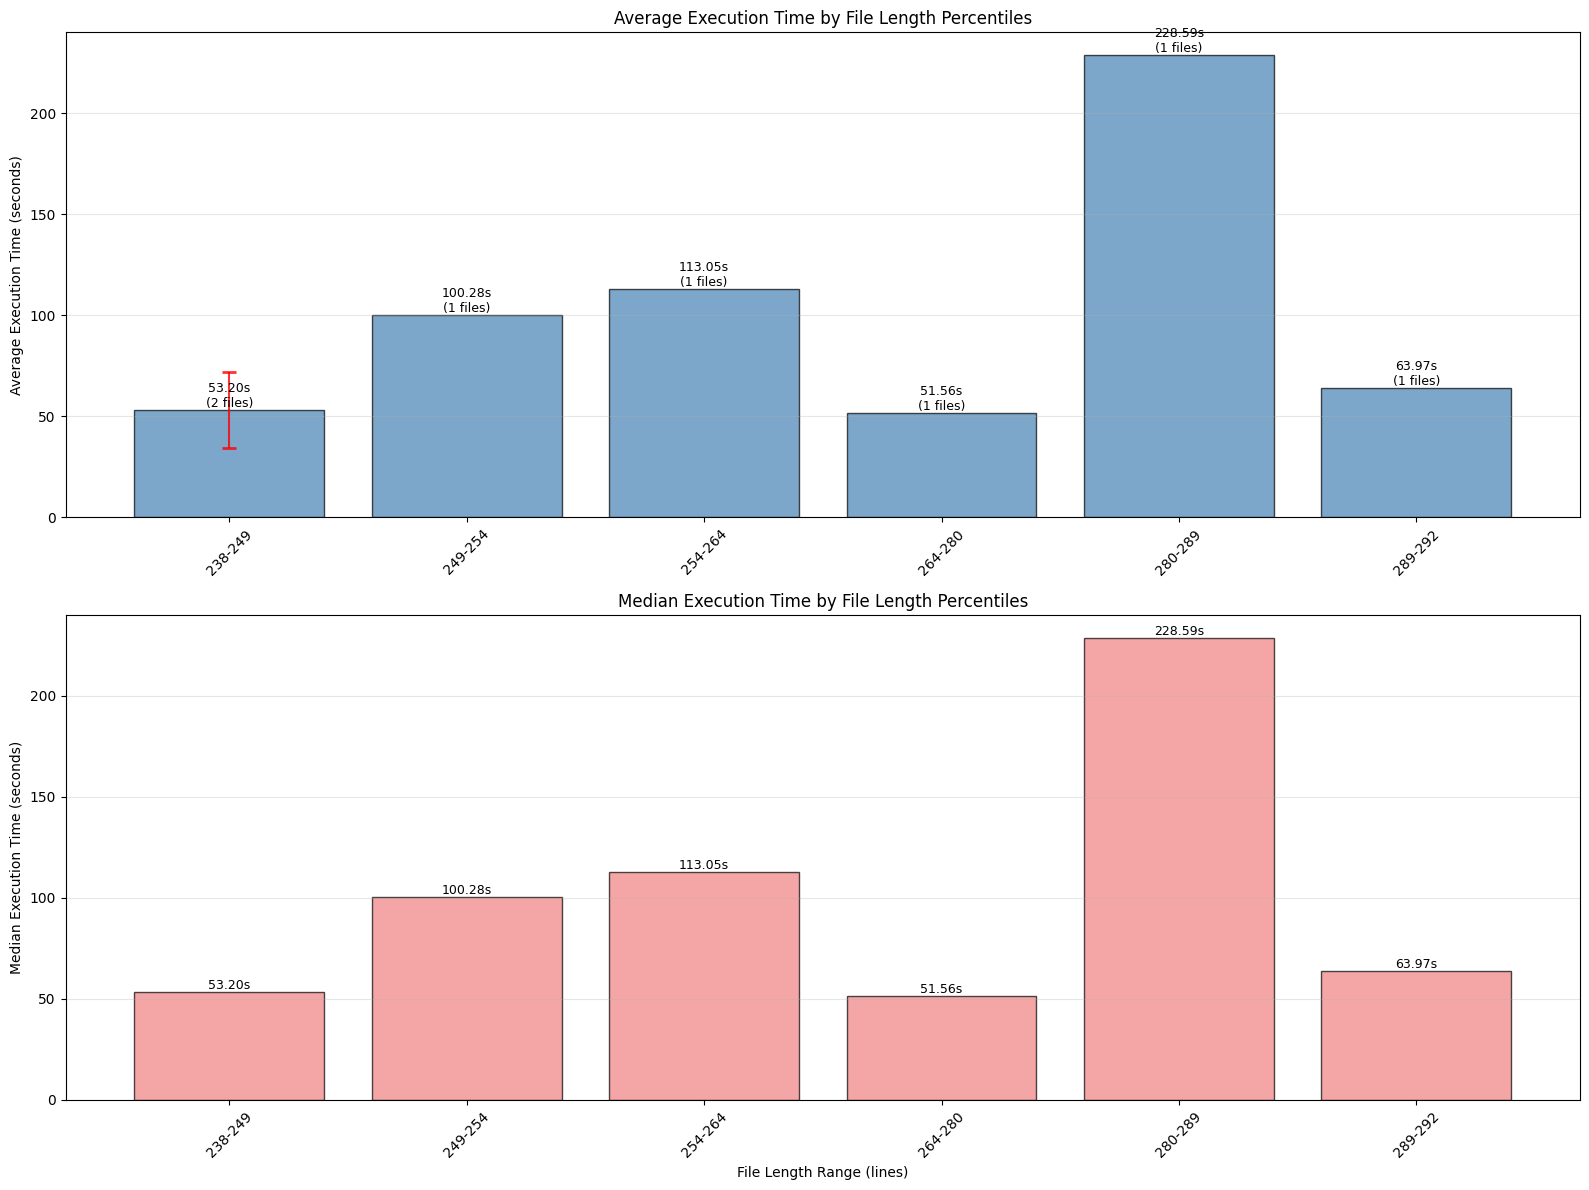

📊 Detailed Statistics by File Length Percentiles:


,length_percentile,avg_time,median_time,std_time,file_count,avg_lines,min_lines,max_lines
0,238-249,53.204,53.204,18.75,2,243.0,238,248
1,249-254,100.275,100.275,NaN,1,254.0,254,254
2,254-264,113.052,113.052,NaN,1,256.0,256,256
3,264-280,51.561,51.561,NaN,1,270.0,270,270
4,280-289,228.591,228.591,NaN,1,283.0,283,283
5,289-292,63.967,63.967,NaN,1,292.0,292,292


In [21]:
if df is not None:
    plt.figure(figsize=(16, 8))
    
    # Create more granular bins based on data distribution
    percentiles = [0, 20, 40, 60, 80, 95, 100]
    bin_edges = [df['line_count'].quantile(p/100) for p in percentiles]
    
    # Ensure unique bin edges
    bin_edges = sorted(list(set(bin_edges)))
    
    # Create labels for bins
    labels = []
    for i in range(len(bin_edges)-1):
        labels.append(f"{int(bin_edges[i])}-{int(bin_edges[i+1])}")
    
    # Assign files to categories
    df['length_percentile'] = pd.cut(df['line_count'], bins=bin_edges, labels=labels, include_lowest=True)
    
    # Calculate statistics
    percentile_stats = df.groupby('length_percentile', observed=True).agg({
        'execution_time_seconds': ['mean', 'median', 'std', 'count'],
        'line_count': ['mean', 'min', 'max']
    }).round(3)
    
    # Flatten column names
    percentile_stats.columns = ['avg_time', 'median_time', 'std_time', 'file_count', 
                               'avg_lines', 'min_lines', 'max_lines']
    percentile_stats = percentile_stats.reset_index()
    
    # Remove empty categories
    percentile_stats = percentile_stats[percentile_stats['file_count'] > 0]
    
    # Create subplot with both average and median
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    
    # Plot 1: Average time with error bars
    bars1 = ax1.bar(range(len(percentile_stats)), percentile_stats['avg_time'], 
                     alpha=0.7, color='steelblue', edgecolor='black')
    ax1.errorbar(range(len(percentile_stats)), percentile_stats['avg_time'], 
                yerr=percentile_stats['std_time'], fmt='none', color='red', 
                capsize=5, capthick=2, alpha=0.8)
    
    ax1.set_ylabel('Average Execution Time (seconds)')
    ax1.set_title('Average Execution Time by File Length Percentiles')
    ax1.set_xticks(range(len(percentile_stats)))
    ax1.set_xticklabels(percentile_stats['length_percentile'], rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add labels
    for i, (bar, avg_time, count) in enumerate(zip(bars1, percentile_stats['avg_time'], percentile_stats['file_count'])):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{avg_time:.2f}s\n({count} files)', 
                ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Median time (more robust to outliers)
    bars2 = ax2.bar(range(len(percentile_stats)), percentile_stats['median_time'], 
                     alpha=0.7, color='lightcoral', edgecolor='black')
    
    ax2.set_xlabel('File Length Range (lines)')
    ax2.set_ylabel('Median Execution Time (seconds)')
    ax2.set_title('Median Execution Time by File Length Percentiles')
    ax2.set_xticks(range(len(percentile_stats)))
    ax2.set_xticklabels(percentile_stats['length_percentile'], rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add labels
    for i, (bar, median_time) in enumerate(zip(bars2, percentile_stats['median_time'])):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{median_time:.2f}s', 
                ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Display detailed table
    print("📊 Detailed Statistics by File Length Percentiles:")
    display(percentile_stats)

📊 Found 3 'classic' files and 3 'affine' files


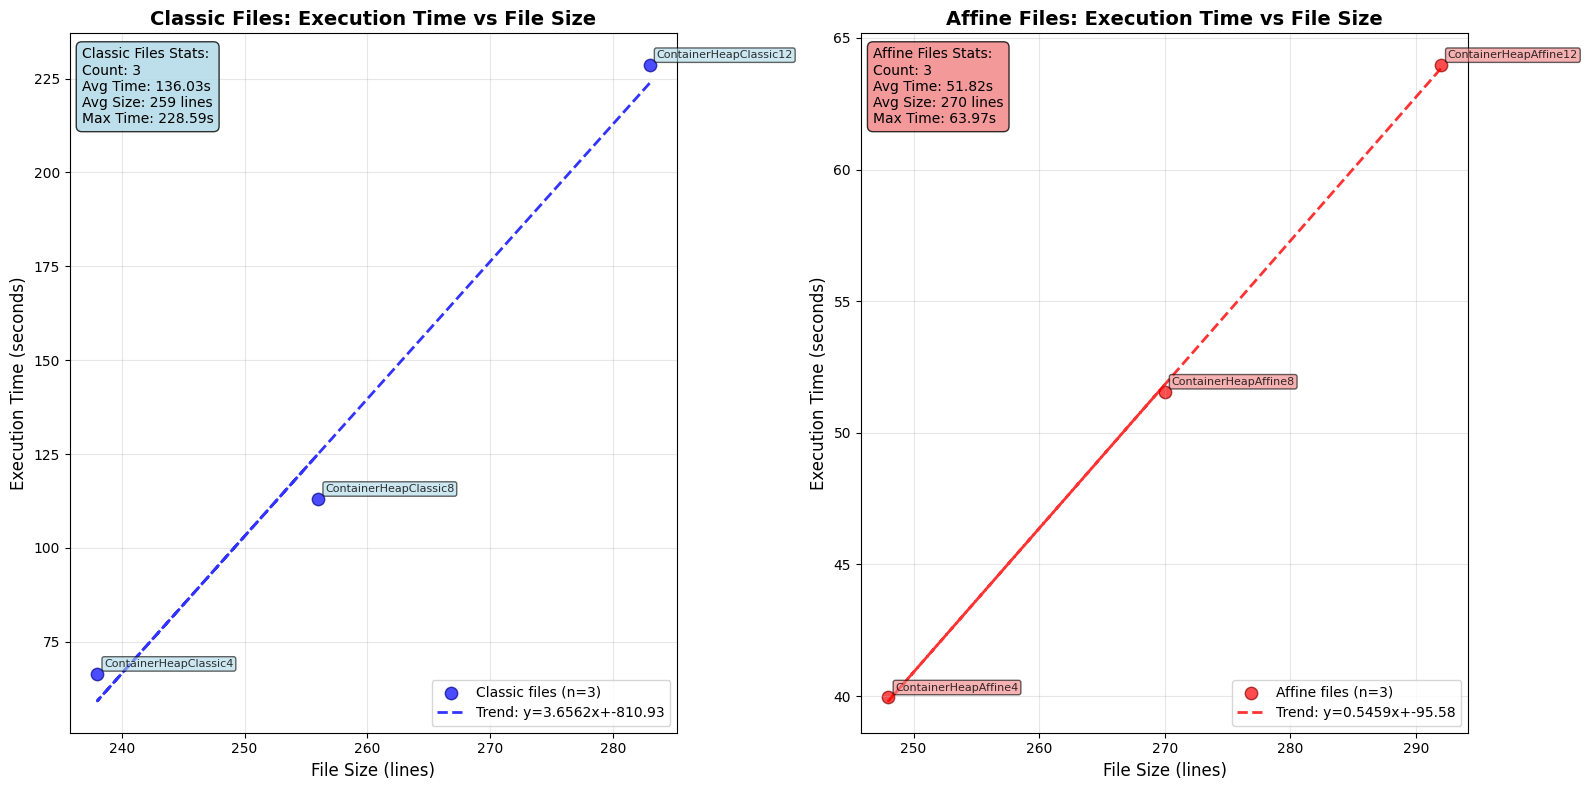


🔍 COMPARATIVE ANALYSIS


,Metric,Classic Files,Affine Files
0,Count,3,3
1,Avg Execution Time (s),136.035,51.824
2,Median Execution Time (s),113.052,51.561
3,Avg File Size (lines),259.0,270.0
4,Median File Size (lines),256.0,270.0
5,Max Execution Time (s),228.591,63.967
6,Min Execution Time (s),66.462,39.945
7,Avg Time per Line (s/line),0.509534,0.190367



📈 Statistical Test (t-test for execution times):
t-statistic: 1.7296
p-value: 0.1588
❌ No statistically significant difference (p ≥ 0.05)

📋 Classic Files Details:


,filename,line_count,execution_time_seconds
3,ContainerHeapClassic12.boogie.st,283,228.590530
5,ContainerHeapClassic8.boogie.st,256,113.051577
4,ContainerHeapClassic4.boogie.st,238,66.462185



📋 Affine Files Details:


,filename,line_count,execution_time_seconds
0,ContainerHeapAffine12.boogie.st,292,63.966613
2,ContainerHeapAffine8.boogie.st,270,51.561076
1,ContainerHeapAffine4.boogie.st,248,39.945120


In [22]:
if df is not None:
    # Filter files by name patterns (case insensitive)
    classic_files = df[df['filename'].str.contains('classic', case=False, na=False)]
    affine_files = df[df['filename'].str.contains('affine', case=False, na=False)]
    
    print(f"📊 Found {len(classic_files)} 'classic' files and {len(affine_files)} 'affine' files")
    
    if len(classic_files) > 0 or len(affine_files) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Plot 1: Classic files - Execution time vs File size
        if len(classic_files) > 0:
            scatter1 = ax1.scatter(classic_files['line_count'], classic_files['execution_time_seconds'], 
                                  alpha=0.7, s=80, c='blue', edgecolors='darkblue', linewidth=1,
                                  label=f'Classic files (n={len(classic_files)})')
            
            # Add trend line for classic files
            if len(classic_files) > 1:
                z1 = np.polyfit(classic_files['line_count'], classic_files['execution_time_seconds'], 1)
                p1 = np.poly1d(z1)
                ax1.plot(classic_files['line_count'], p1(classic_files['line_count']), 
                        "b--", alpha=0.8, linewidth=2,
                        label=f'Trend: y={z1[0]:.4f}x+{z1[1]:.2f}')
            
            # Annotate points with filenames
            for _, row in classic_files.iterrows():
                ax1.annotate(row['filename'].replace('.boogie.st', '').replace('classic', 'C'), 
                           (row['line_count'], row['execution_time_seconds']),
                           xytext=(5, 5), textcoords='offset points', 
                           fontsize=8, alpha=0.8,
                           bbox=dict(boxstyle="round,pad=0.2", facecolor="lightblue", alpha=0.6))
            
            ax1.set_xlabel('File Size (lines)', fontsize=12)
            ax1.set_ylabel('Execution Time (seconds)', fontsize=12)
            ax1.set_title('Classic Files: Execution Time vs File Size', fontsize=14, fontweight='bold')
            ax1.grid(True, alpha=0.3)
            ax1.legend()
            
            # Add statistics text box
            classic_stats = f"""Classic Files Stats:
Count: {len(classic_files)}
Avg Time: {classic_files['execution_time_seconds'].mean():.2f}s
Avg Size: {classic_files['line_count'].mean():.0f} lines
Max Time: {classic_files['execution_time_seconds'].max():.2f}s"""
            
            ax1.text(0.02, 0.98, classic_stats, transform=ax1.transAxes, 
                    fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="lightblue", alpha=0.8))
        else:
            ax1.text(0.5, 0.5, 'No files with "classic" found', 
                    transform=ax1.transAxes, ha='center', va='center', fontsize=14)
            ax1.set_title('Classic Files: No Data', fontsize=14, fontweight='bold')
        
        # Plot 2: Affine files - Execution time vs File size
        if len(affine_files) > 0:
            scatter2 = ax2.scatter(affine_files['line_count'], affine_files['execution_time_seconds'], 
                                  alpha=0.7, s=80, c='red', edgecolors='darkred', linewidth=1,
                                  label=f'Affine files (n={len(affine_files)})')
            
            # Add trend line for affine files
            if len(affine_files) > 1:
                z2 = np.polyfit(affine_files['line_count'], affine_files['execution_time_seconds'], 1)
                p2 = np.poly1d(z2)
                ax2.plot(affine_files['line_count'], p2(affine_files['line_count']), 
                        "r--", alpha=0.8, linewidth=2,
                        label=f'Trend: y={z2[0]:.4f}x+{z2[1]:.2f}')
            
            # Annotate points with filenames
            for _, row in affine_files.iterrows():
                ax2.annotate(row['filename'].replace('.boogie.st', '').replace('affine', 'A'), 
                           (row['line_count'], row['execution_time_seconds']),
                           xytext=(5, 5), textcoords='offset points', 
                           fontsize=8, alpha=0.8,
                           bbox=dict(boxstyle="round,pad=0.2", facecolor="lightcoral", alpha=0.6))
            
            ax2.set_xlabel('File Size (lines)', fontsize=12)
            ax2.set_ylabel('Execution Time (seconds)', fontsize=12)
            ax2.set_title('Affine Files: Execution Time vs File Size', fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3)
            ax2.legend()
            
            # Add statistics text box
            affine_stats = f"""Affine Files Stats:
Count: {len(affine_files)}
Avg Time: {affine_files['execution_time_seconds'].mean():.2f}s
Avg Size: {affine_files['line_count'].mean():.0f} lines
Max Time: {affine_files['execution_time_seconds'].max():.2f}s"""
            
            ax2.text(0.02, 0.98, affine_stats, transform=ax2.transAxes, 
                    fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="lightcoral", alpha=0.8))
        else:
            ax2.text(0.5, 0.5, 'No files with "affine" found', 
                    transform=ax2.transAxes, ha='center', va='center', fontsize=14)
            ax2.set_title('Affine Files: No Data', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Comparative analysis
        if len(classic_files) > 0 and len(affine_files) > 0:
            print("\n🔍 COMPARATIVE ANALYSIS")
            print("=" * 50)
            
            comparison_data = {
                'Metric': ['Count', 'Avg Execution Time (s)', 'Median Execution Time (s)', 
                          'Avg File Size (lines)', 'Median File Size (lines)', 
                          'Max Execution Time (s)', 'Min Execution Time (s)',
                          'Avg Time per Line (s/line)'],
                'Classic Files': [
                    len(classic_files),
                    f"{classic_files['execution_time_seconds'].mean():.3f}",
                    f"{classic_files['execution_time_seconds'].median():.3f}",
                    f"{classic_files['line_count'].mean():.1f}",
                    f"{classic_files['line_count'].median():.1f}",
                    f"{classic_files['execution_time_seconds'].max():.3f}",
                    f"{classic_files['execution_time_seconds'].min():.3f}",
                    f"{(classic_files['execution_time_seconds'] / classic_files['line_count']).mean():.6f}"
                ],
                'Affine Files': [
                    len(affine_files),
                    f"{affine_files['execution_time_seconds'].mean():.3f}",
                    f"{affine_files['execution_time_seconds'].median():.3f}",
                    f"{affine_files['line_count'].mean():.1f}",
                    f"{affine_files['line_count'].median():.1f}",
                    f"{affine_files['execution_time_seconds'].max():.3f}",
                    f"{affine_files['execution_time_seconds'].min():.3f}",
                    f"{(affine_files['execution_time_seconds'] / affine_files['line_count']).mean():.6f}"
                ]
            }
            
            comparison_df = pd.DataFrame(comparison_data)
            display(comparison_df)
            
            # Statistical significance test (if both groups have enough samples)
            if len(classic_files) >= 3 and len(affine_files) >= 3:
                from scipy import stats
                t_stat, p_value = stats.ttest_ind(classic_files['execution_time_seconds'], 
                                                 affine_files['execution_time_seconds'])
                print(f"\n📈 Statistical Test (t-test for execution times):")
                print(f"t-statistic: {t_stat:.4f}")
                print(f"p-value: {p_value:.4f}")
                if p_value < 0.05:
                    print("✅ Statistically significant difference (p < 0.05)")
                else:
                    print("❌ No statistically significant difference (p ≥ 0.05)")
        
        # Show individual file details
        if len(classic_files) > 0:
            print(f"\n📋 Classic Files Details:")
            display(classic_files[['filename', 'line_count', 'execution_time_seconds']].sort_values('execution_time_seconds', ascending=False))
        
        if len(affine_files) > 0:
            print(f"\n📋 Affine Files Details:")
            display(affine_files[['filename', 'line_count', 'execution_time_seconds']].sort_values('execution_time_seconds', ascending=False))
            
    else:
        print("❌ No files found with 'classic' or 'affine' in their names")

/var/folders/p5/ks5m_6tn0cl9zk8rttvqpqyh0000gq/T/ipykernel_37548/2599933104.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(data_to_plot, labels=labels, patch_artist=True)


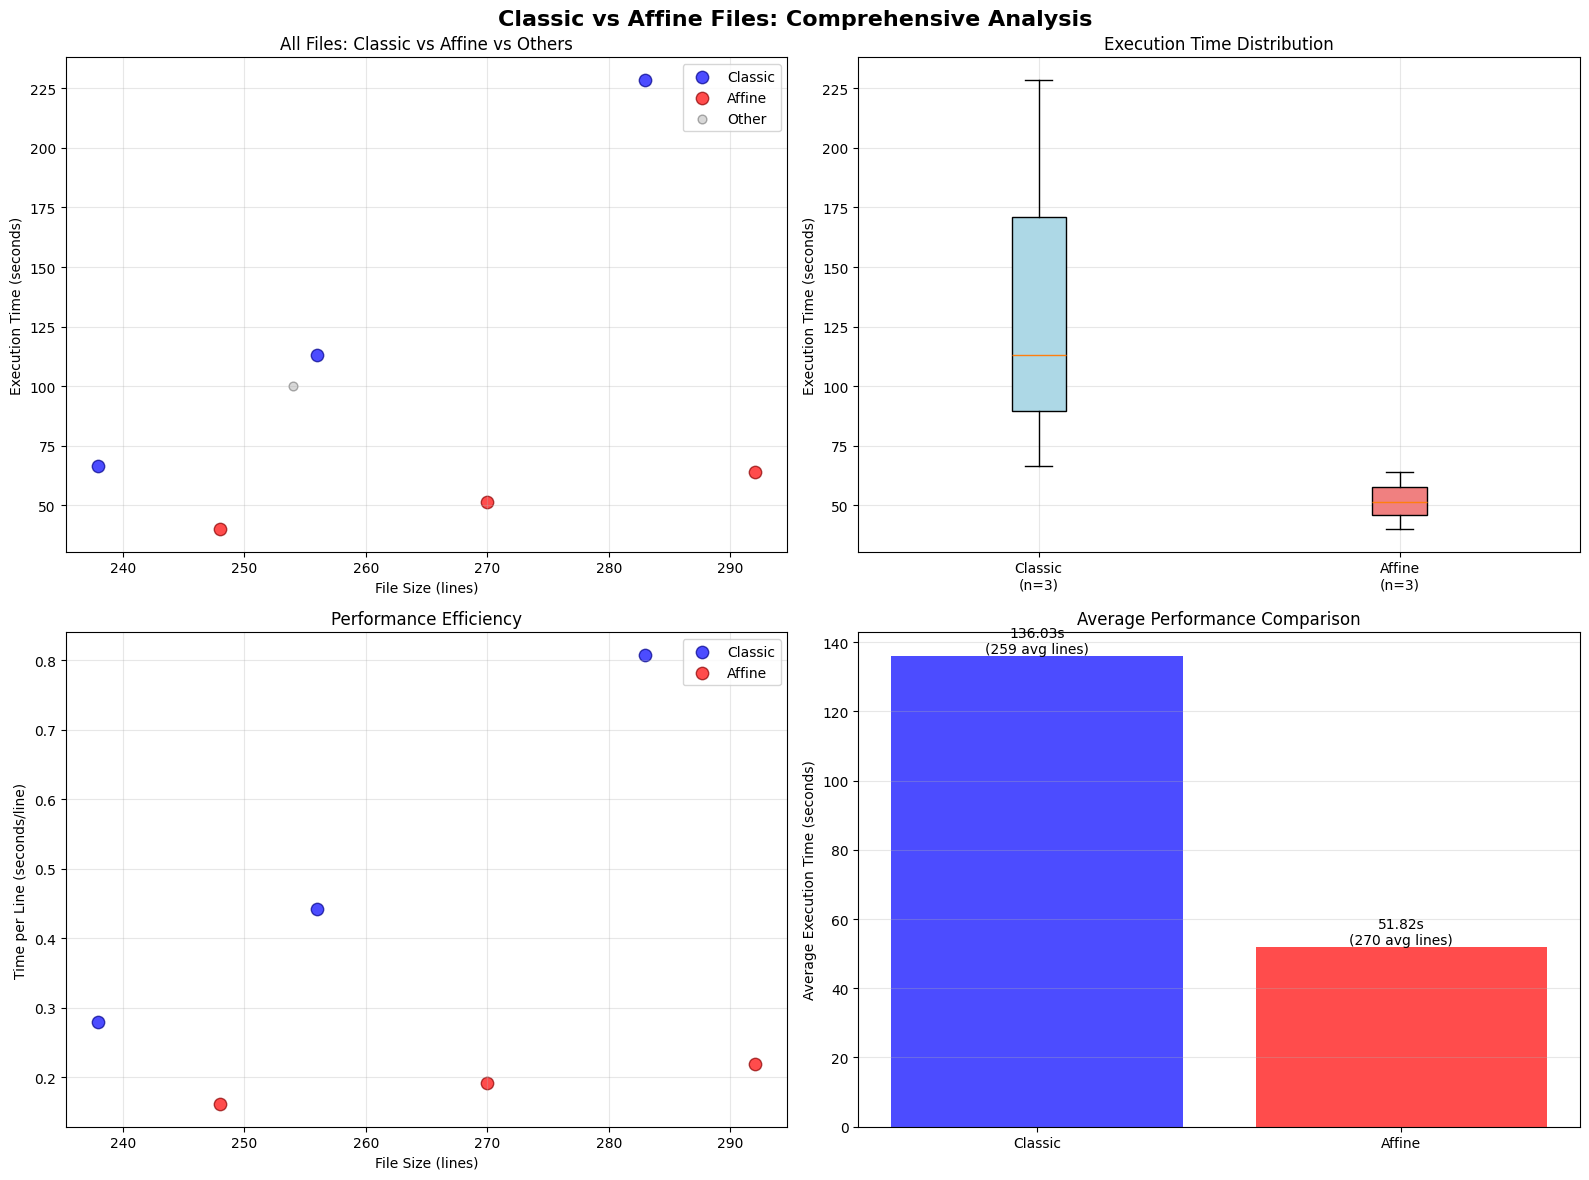

In [23]:
# Cell: Extended Classic vs Affine Analysis
if df is not None:
    # Filter files by name patterns (case insensitive)
    classic_files = df[df['filename'].str.contains('classic', case=False, na=False)]
    affine_files = df[df['filename'].str.contains('affine', case=False, na=False)]
    other_files = df[~df['filename'].str.contains('classic|affine', case=False, na=False)]
    
    if len(classic_files) > 0 or len(affine_files) > 0:
        # Create a comprehensive comparison
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Classic vs Affine Files: Comprehensive Analysis', fontsize=16, fontweight='bold')
        
        # Plot 1: Scatter plots side by side
        if len(classic_files) > 0:
            ax1.scatter(classic_files['line_count'], classic_files['execution_time_seconds'], 
                       alpha=0.7, s=80, c='blue', label='Classic', edgecolors='darkblue')
        if len(affine_files) > 0:
            ax1.scatter(affine_files['line_count'], affine_files['execution_time_seconds'], 
                       alpha=0.7, s=80, c='red', label='Affine', edgecolors='darkred')
        if len(other_files) > 0:
            ax1.scatter(other_files['line_count'], other_files['execution_time_seconds'], 
                       alpha=0.3, s=40, c='gray', label='Other', edgecolors='black')
        
        ax1.set_xlabel('File Size (lines)')
        ax1.set_ylabel('Execution Time (seconds)')
        ax1.set_title('All Files: Classic vs Affine vs Others')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Box plots for comparison
        data_to_plot = []
        labels = []
        if len(classic_files) > 0:
            data_to_plot.append(classic_files['execution_time_seconds'])
            labels.append(f'Classic\n(n={len(classic_files)})')
        if len(affine_files) > 0:
            data_to_plot.append(affine_files['execution_time_seconds'])
            labels.append(f'Affine\n(n={len(affine_files)})')
        
        if data_to_plot:
            bp = ax2.boxplot(data_to_plot, labels=labels, patch_artist=True)
            colors = ['lightblue', 'lightcoral']
            for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
                patch.set_facecolor(color)
        
        ax2.set_ylabel('Execution Time (seconds)')
        ax2.set_title('Execution Time Distribution')
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Performance efficiency (time per line)
        if len(classic_files) > 0:
            classic_efficiency = classic_files['execution_time_seconds'] / classic_files['line_count']
            ax3.scatter(classic_files['line_count'], classic_efficiency, 
                       alpha=0.7, s=80, c='blue', label='Classic', edgecolors='darkblue')
        if len(affine_files) > 0:
            affine_efficiency = affine_files['execution_time_seconds'] / affine_files['line_count']
            ax3.scatter(affine_files['line_count'], affine_efficiency, 
                       alpha=0.7, s=80, c='red', label='Affine', edgecolors='darkred')
        
        ax3.set_xlabel('File Size (lines)')
        ax3.set_ylabel('Time per Line (seconds/line)')
        ax3.set_title('Performance Efficiency')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Bar chart of averages
        categories = []
        avg_times = []
        avg_sizes = []
        
        if len(classic_files) > 0:
            categories.append('Classic')
            avg_times.append(classic_files['execution_time_seconds'].mean())
            avg_sizes.append(classic_files['line_count'].mean())
        
        if len(affine_files) > 0:
            categories.append('Affine')
            avg_times.append(affine_files['execution_time_seconds'].mean())
            avg_sizes.append(affine_files['line_count'].mean())
        
        if categories:
            x_pos = np.arange(len(categories))
            bars = ax4.bar(x_pos, avg_times, alpha=0.7, 
                          color=['blue' if cat == 'Classic' else 'red' for cat in categories])
            
            # Add value labels on bars
            for bar, time, size in zip(bars, avg_times, avg_sizes):
                ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                        f'{time:.2f}s\n({size:.0f} avg lines)', 
                        ha='center', va='bottom', fontsize=10)
            
            ax4.set_xticks(x_pos)
            ax4.set_xticklabels(categories)
            ax4.set_ylabel('Average Execution Time (seconds)')
            ax4.set_title('Average Performance Comparison')
            ax4.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
